In [1]:
import models
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score
import cv2
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from PIL import Image
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='torchvision')

class ImageDataset(Dataset):
    def __init__(self, csv, train, test):
        self.csv = csv
        self.train = train
        self.test = test
        self.all_image_names = self.csv[:]['ID']
        self.all_labels = np.array(self.csv.drop(['ID', 'Target_List'], axis=1))
        self.train_ratio = int(0.85 * len(self.csv))
        self.valid_ratio = len(self.csv) - self.train_ratio
        # set the training data images and labels
        print(f"Number of training images: {self.train_ratio}")
        self.image_names = list(self.all_image_names[:self.train_ratio])
        self.labels = list(self.all_labels[:self.train_ratio])
        # define the training transforms
        self.transform = transforms.Compose([
            transforms.ToTensor(),
        ])
        
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, index):
        file_path = f"../input/drug-classifier/drug_CNN/Table_To_Image_Conversion/10k/data/_{self.image_names[index]}_data.txt"
        image = np.loadtxt(file_path) # replaces transforms.ToPILImage() because these values are already 0-255 (though not integers)
        
        # Convert the numpy array to a PIL Image
        image = Image.fromarray((image).astype('uint8'), mode='L')
        
        # apply image transforms
        image = self.transform(image)
        targets = self.labels[index]
        
        return {
            'image': torch.tensor(image, dtype=torch.float32),
            'label': torch.tensor(targets, dtype=torch.float32)
        }


In [2]:

# initialize the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# initialize the model
model = models.model(pretrained=False, requires_grad=False).to(device)
# load the model checkpoint
checkpoint = torch.load('../outputs/model.pth')
# load model weights state_dict
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

train_csv_original = pd.read_csv('../input/drug-classifier/drug_CNN/train_drugidx.csv')
#train_csv = train_csv_original[~train_csv_original['Target_List'].str.contains('Others', case=False)] # Filter the categories to not include others
#genres = train_csv.columns.values[2:]
#print('Original and filtered lengths:', len(train_csv_original), len(train_csv))
#print('Removed elements:', len(train_csv_original)-len(train_csv))

# prepare the test dataset and dataloader
test_data = ImageDataset(
    train_csv_original, train=True, test=False
)


Number of training images: 9255


In [3]:
test_loader = DataLoader(
    test_data, 
    batch_size=len(test_data.csv),
    shuffle=False
)

x = next(iter(test_loader))
image_tensor = x['image']
label_tensor = x['label']

<ipython-input-1-4fafa344cc8d>:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


In [4]:
image_tensor.shape

torch.Size([9255, 1, 60, 60])

In [5]:
import torch
import umap.umap_ as umap
import numpy as np
import matplotlib.pyplot as plt

# Flatten the image tensor and convert to a NumPy array
# This assumes image_tensor is of shape (N, C, H, W) where
# N is the number of images, C is the number of channels,
# H is the height, and W is the width of the image.
flattened_images = image_tensor.view(image_tensor.size(0), -1).numpy()

# Convert the label tensor to a NumPy array
labels = label_tensor.numpy()
labels = np.argmax(labels, axis=1)

In [6]:
flattened_images.shape

(9255, 3600)

In [7]:
flattened_images

array([[0.        , 0.04705882, 0.13725491, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.04705882, 0.13725491, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.04705882, 0.13725491, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.04705882, 0.13725491, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.04705882, 0.13725491, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.04705882, 0.13725491, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [8]:

# Initialize UMAP
reducer = umap.UMAP()

# Fit UMAP on the image data
embedding = reducer.fit_transform(flattened_images)


In [13]:
import plotly.express as px

# Assuming 'embedding' is your UMAP output and 'labels' are your class labels

# Convert labels to string if they are not already, for better tooltip display
labels_str = [str(label) for label in labels]

# Create a Plotly scatter plot
fig = px.scatter(
    x=embedding[:, 0], 
    y=embedding[:, 1], 
    color=labels_str,
    color_continuous_scale='Spectral',  # You can choose other color scales
    labels={'color': 'Label'},
    title='UMAP projection of image data\n60x60 - no randomization'
)

# Update layout for better visualization
fig.update_layout(
    xaxis_title="UMAP 1",
    yaxis_title="UMAP 2",
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False),
    plot_bgcolor='rgba(0,0,0,0)'
)

# Show the figure
fig.show()


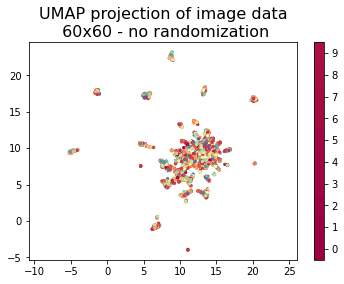

In [9]:
# Plot the embedding
plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of image data\n 60x60 - no randomization', fontsize=16)
plt.show()

In [ ]:
import umap.umap_ as umap
import numpy as np
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt

# load in data

Example with MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data / 255.0
y = mnist.target


In [ ]:
import torch
import cv2
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset

class ImageDataset(Dataset):
    def __init__(self, csv, train, test):
        self.csv = csv
        self.train = train
        self.test = test
        self.all_image_names = self.csv[:]['Id']
        self.all_labels = np.array(self.csv.drop(['ID', 'Target_List'], axis=1))
        self.train_ratio = int(0.85 * len(self.csv))
        self.valid_ratio = len(self.csv) - self.train_ratio
        # set the training data images and labels
        if self.train == True:
            print(f"Number of training images: {self.train_ratio}")
            self.image_names = list(self.all_image_names[:self.train_ratio])
            self.labels = list(self.all_labels[:self.train_ratio])
            # define the training transforms
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((400, 400)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=45),
                transforms.ToTensor(),
            ])
        # set the validation data images and labels
        elif self.train == False and self.test == False:
            print(f"Number of validation images: {self.valid_ratio}")
            self.image_names = list(self.all_image_names[-self.valid_ratio:-10])
            self.labels = list(self.all_labels[-self.valid_ratio:-10])
            # define the validation transforms
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((400, 400)),
                transforms.ToTensor(),
            ])
        # set the test data images and labels, only last 10 images
        # this, we will use in a separate inference script
        elif self.test == True and self.train == False:
            self.image_names = list(self.all_image_names[-10:])
            self.labels = list(self.all_labels[-10:])
             # define the test transforms
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.ToTensor(),
            ])
            
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, index):
        file_path = f"../input/drug-classifier/drug_CNN/Table_To_Image_Conversion/10k/data/_{self.image_names[index]}_data.txt"
        data = np.loadtxt(file_path)/255 # replaces transforms.ToPILImage() because these values are already 0-255 (though not integers)
        
        # apply image transforms
        image = self.transform(image)
        
        targets = self.labels[index]
        
        return {
            'image': torch.tensor(image, dtype=torch.float32),
            'label': torch.tensor(targets, dtype=torch.float32)
        }

import pandas as pd

train_csv = pd.read_csv('../input/drug-classifier/drug_CNN/train_drugidx.csv')
labels=np.array(train_csv.drop(['ID', 'Target_List'], axis=1))

In [ ]:
labels

In [ ]:
# Initialize UMAP
reducer = umap.UMAP()

# Fit the model to your data
embedding = reducer.fit_transform(X)

# Plot the embedding
plt.scatter(embedding[:, 0], embedding[:, 1], c=y.astype(int), cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the MNIST dataset', fontsize=24)
